In [1]:
#%% import packages:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

In [2]:
#%% check if cuda is available:
if torch.cuda.is_available():
    print('cuda is available')
    device = torch.device("cuda:0")
else:
    print('cuda is not available')
    device = torch.device("cpu")

cuda is not available


In [90]:
import csv

# Function to merge rows from two CSV files
def merge_csv(input_file, output_file):
    # Initialize lists to store the selected rows
    first_500_1000_rows = []
    rows_after_8777 = []

    with open(input_file, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if 500 <= i < 1000:
                first_500_1000_rows.append(row)
            elif i >= 8777 and i < 9277:
                rows_after_8777.append(row)
    
    # Merge the selected rows
    merged_rows = first_500_1000_rows + rows_after_8777

    # Write the merged rows to a new CSV file
    with open(output_file, 'w', newline='') as new_csvfile:
        writer = csv.writer(new_csvfile)
        writer.writerows(merged_rows)

# Input and output file paths
input_file_path = 'data/extended_tackles_with_tracking_full.csv'  # Replace with your input CSV file path
output_file_path = 'data/extended_tackles_with_tracking_mixed_1000.csv'  # Replace with the desired output CSV file path

# Call the merge_csv function
merge_csv(input_file_path, output_file_path)

print(f"The first 500 rows and 500 rows after row 8777 have been merged into '{output_file_path}'.")

The first 500 rows and 500 rows after row 8777 have been merged into 'data/extended_tackles_with_tracking_mixed_1000.csv'.


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

max_field_width = 53.3  # in yards
max_field_height = 120  # in yards
num_channels = 8  # 2 for position, 3 for player attributes, 3 for ball attributes
max_distance = 50.08118409143298

class NFLDataset(Dataset):
    def __init__(self, csv_file, grid_size, transform=None):
        self.nfl_data = pd.read_csv(csv_file)
        self.grid_size = grid_size
        self.transform = transform

    def __len__(self):
        return len(self.nfl_data)

    def __getitem__(self, idx):
        data_row = self.nfl_data.iloc[idx]

        # Initialize a grid with multiple channels
        grid = np.zeros((num_channels, *self.grid_size))

        # Center of the grid
        center_x, center_y = self.grid_size[0] // 2, self.grid_size[1] // 2

        # Normalize and translate player and ball positions
        ball_x, ball_y = data_row['ball_x'], data_row['ball_y']
        player_x, player_y = data_row['player_x'], data_row['player_y']

        # Normalize positions
        norm_player_x = int((player_x - ball_x) / max_field_width * self.grid_size[0]) + center_x
        norm_player_y = int((player_y - ball_y) / max_field_height * self.grid_size[1]) + center_y

        # Ensure the normalized positions are within bounds
        norm_player_x = max(0, min(self.grid_size[0] - 1, norm_player_x))
        norm_player_y = max(0, min(self.grid_size[1] - 1, norm_player_y))

        # Place player and ball in their respective position layers
        grid[0, norm_player_x, norm_player_y] = 1  # Player position layer
        grid[1, center_x, center_y] = 1  # Ball position layer (always at the center)

        # Populate other attribute layers (speed, acceleration, direction) for player and ball
        # Normalize these attributes as needed
        grid[2, norm_player_x, norm_player_y] = data_row['player_s']  # Player speed
        grid[3, norm_player_x, norm_player_y] = data_row['player_a']  # Player acceleration
        grid[4, norm_player_x, norm_player_y] = data_row['player_dir']  # Player direction
        grid[5, center_x, center_y] = data_row['ball_s']  # Ball speed
        grid[6, center_x, center_y] = data_row['ball_a']  # Ball acceleration
        grid[7, center_x, center_y] = data_row['ball_dir']  # Ball direction

        grid_tensor = torch.tensor(grid, dtype=torch.float32)
        # print(grid_tensor.shape)

        label = torch.tensor(data_row['tackle'], dtype=torch.float32)
        label.item()
        # print(label.shape)

        if self.transform:
            grid_tensor = self.transform(grid_tensor)

        return grid_tensor, label

# Usage example
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_mixed_1000.csv', grid_size=(150, 150))

# Create a DataLoader
dataloader = DataLoader(nfl_dataset, batch_size=1, shuffle=True)

# Example of iterating over the DataLoader
for grid, label in dataloader:
    print(grid.shape, label.shape)
    break  # Remove this to iterate over the entire dataset


torch.Size([1, 8, 150, 150]) torch.Size([1])


Label: 1.0


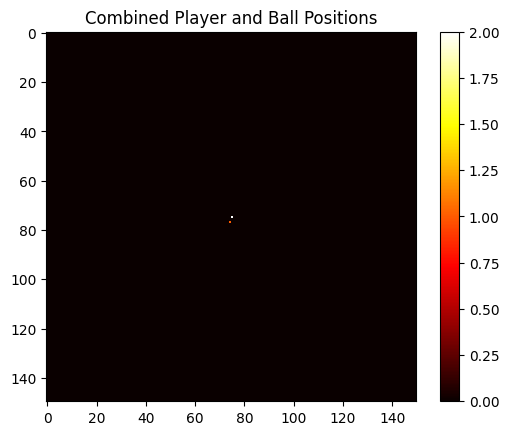

In [4]:
def visualize_grid(grid):
    # Create a combined grid for visualization
    # Assuming channel 0 is player position and channel 1 is ball position
    combined_grid = np.zeros_like(grid[0])
    combined_grid[grid[0] == 1] = 1  # Mark player positions
    combined_grid[grid[1] == 1] = 2  # Mark ball positions

    # Visualize the combined grid
    plt.imshow(combined_grid, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Combined Player and Ball Positions')
    plt.show()

# Usage example
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_mixed.csv', grid_size=(150, 150))

# Test the visualization
for i in range(19,20):  # Visualize the first 3 examples
    grid, label = nfl_dataset[i]
    print(f"Label: {label}")
    visualize_grid(grid.numpy())


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_channels=8):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * 75 * 75, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)
    
class LargerCNN(nn.Module):
    def __init__(self, num_channels=8):
        super(LargerCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        

        # Assuming input image size is 150x150
        self.fc1 = nn.Linear(175232, 512)  # Adjusted the input size
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)

        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Output layer with sigmoid activation for binary classification
        x = self.fc4(x)
        return torch.sigmoid(x)

In [6]:
model = SimpleCNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [151]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [7]:
def calculate_accuracy(data_loader, model):
    correct_predictions = 0
    total_samples = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)

            # Apply a threshold (e.g., 0.5) to the model's output to convert it into binary predictions
            predictions = (outputs >= 0.5).float()

            # Count correct predictions
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate the accuracy
    accuracy = (correct_predictions / total_samples) * 100.0
    return accuracy

In [8]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
#nfl_dataset_big = NFLDataset(csv_file='extended_tackles_with_tracking.csv', grid_size=(50, 50))
nfl_dataset = NFLDataset(csv_file='data/extended_tackles_with_tracking_mixed_1000.csv', grid_size=(150, 150))

# Define the proportions
total_size = len(nfl_dataset)  # Use the nfl_dataset instance you already created
train_size = int(total_size * 0.7)  # 70% of data
val_size = int(total_size * 0.2)  # 20% of data
test_size = total_size - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(nfl_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [154]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # Add a singleton dimension for the output
        #outputs = torch.squeeze(outputs)  # Squeeze the output to match label's shape
        loss = loss_function(outputs, labels.float()) # Ensure labels are float type
        loss.backward()
        optimizer.step()

    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader, model)

    # Switch model to evaluation mode for validation accuracy
    model.eval()
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.4f}%, Validation Accuracy: {val_accuracy:.4f}%')


KeyboardInterrupt: 

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0.0  # Initialize total loss for training

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        total_loss_train += loss.item() * len(batch)  # Accumulate the loss

    average_loss_train = total_loss_train / len(train_loader.dataset)  # Calculate average loss

    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader, model)

    # Switch model to evaluation mode for validation loss and accuracy
    model.eval()
    total_loss_val = 0.0  # Initialize total loss for validation

    for batch in val_loader:
        inputs, labels = batch
        outputs = model(inputs).squeeze(1)
        loss = loss_function(outputs, labels.float())
        
        total_loss_val += loss.item() * len(batch)  # Accumulate the loss

    average_loss_val = total_loss_val / len(val_loader.dataset)  # Calculate average loss

    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss_train:.4f}, Training Accuracy: {train_accuracy:.4f}%, Validation Loss: {average_loss_val:.4f}, Validation Accuracy: {val_accuracy:.4f}%')


Epoch 1/10, Training Loss: 97.1449, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 2/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 3/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 4/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 5/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 6/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 7/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 8/10, Training Loss: 97.1429, Training Accuracy: 51.4286%, Validation Loss: 105.0000, Validation Accuracy: 47.5000%
Epoch 9/10, Training Los